In [ ]:
# import libraries
import os
import pandas as pd
import numpy as np

import cv2
from skimage.feature import hog

from sklearn.model_selection import train_test_split

from sklearn.decomposition import PCA

# libraries for data plotting
import seaborn as sns
import matplotlib.pyplot as plt 

# library for evaluation
from sklearn import metrics

# libraries for ML algorithms
from sklearn import svm

from random import randint
from random import seed

RANDOM_SEED = 100

Drive and file setup

In [ ]:
# mount your Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
 # unzip file
import shutil
shutil.unpack_archive('/content/drive/MyDrive/Colab Notebooks/train_images.zip')

In [ ]:
# unzip file
import shutil
shutil.unpack_archive('/content/drive/MyDrive/Colab Notebooks/test_images.zip')

##Load image data sets

In [ ]:
data_train = ('/content/drive/MyDrive/Colab Notebooks/train.csv')

In [ ]:
data_test = ('/content/drive/MyDrive/Colab Notebooks/test.csv')

In [ ]:
# load training data
df_train = pd.read_csv(os.path.join(data_train))

# summarise the details
print(f'Number of entries: {len(df_train)}')
df_train.head()

Number of entries: 10000


,id,label
0,1,cat
1,2,dog
2,3,cat
3,4,cat
4,5,cat


In [ ]:
# load testing data
df_test = pd.read_csv(os.path.join(data_test))

# summarise the details
print(f'Number of entries: {len(df_test)}')
df_test.head()

Number of entries: 1000


,id
0,1
1,2
2,3
3,4
4,5


<AxesSubplot:xlabel='label', ylabel='count'>

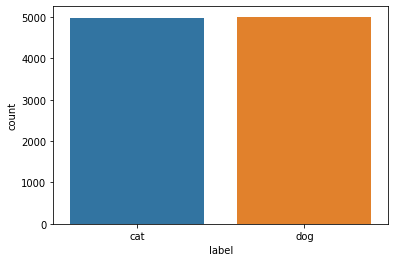

In [ ]:
# Summarise label details in training data
sns.countplot(x=df_train['label'])

Let's write a function to load images.

In [ ]:
# parameters
# ids - list of image ids
# folder_path - path to image folder
# dim - dimensions to resize images
def load_images(ids, folder_path, dim):
  images = []
  for id in ids:
    image_path = os.path.join(folder_path, f'{id}.jpg')
    img = cv2.imread(image_path)

    # Resize if necessary
    if img.shape[0] != dim[1] or img.shape[1] != dim[0]:
      img = cv2.resize(img, dim)
    images.append(img)
  return images

In [ ]:
base_dim = (200, 200)

# load train images
train_image_folder = os.path.join('train_images')
train_images = load_images(df_train['id'][0:9000], train_image_folder, base_dim)
print(f'Number of training images loaded: {len(train_images)}')

# load test images
test_image_folder = os.path.join('test_images')
test_images = load_images(df_test['id'], test_image_folder, base_dim)
print(f'Number of testing images loaded: {len(test_images)}')

Number of training images loaded: 9000
Number of testing images loaded: 1000


## Feature extraction and model generation

In [ ]:
# method to plot confusion matrix
def plot_confusion_matrix(matrix):
    plt.clf()
    plt.imshow(matrix, interpolation='nearest', cmap=plt.cm.Set2_r)
    classNames = ['0', '1']
    plt.title('Confusion Matrix')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    tick_marks = np.arange(len(classNames))
    plt.xticks(tick_marks, classNames)
    plt.yticks(tick_marks, classNames)
    s = [['TN','FP'], ['FN', 'TP']]

    for i in range(2):
        for j in range(2):
            plt.text(j,i, str(s[i][j])+" = "+str(matrix[i][j]))
    plt.show()

# method to calculate evaluation results
def evaluate(actuals, predictions):
  accuracy = metrics.accuracy_score(actuals, predictions)
  confusion_matrix = metrics.confusion_matrix(actuals, predictions)
  return accuracy, confusion_matrix

### SVM

In [ ]:
'''def build_svm_model(X_train, X_val, y_train, y_val):
  # build model
  clf = svm.SVC(kernel='linear', random_state=RANDOM_SEED) 
  clf.fit(X_train, y_train)
  return clf '''

"def build_svm_model(X_train, X_val, y_train, y_val):\n  # build model\n  clf = svm.SVC(kernel='linear', random_state=RANDOM_SEED) \n  clf.fit(X_train, y_train)\n  return clf "

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

def build_knn_model(X_train, X_val, y_train, y_val):
  # build model
  clf = KNeighborsClassifier(n_neighbors=3) 
  clf.fit(X_train, y_train)
  return clf

#### Model M5

Let's try to combine features.

- Preprocessing - gray scaling <br>
- Features - image vector + edge map vector<br>
- Algorithm - SVM <br>

In [ ]:
# method to get image features
def get_features_m5(images):
  features_list = []
  for img in images:
    # image preprocessing
    img_grayscaled = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  
    # feature extraction
    edges_canny = cv2.Canny(img_grayscaled, 100, 200) 
    features1 = img_grayscaled.flatten()
    features2 = edges_canny.flatten()
    features = np.hstack((features1, features2))

    features_list.append(features)

  features_list = np.array(features_list)
  return features_list

Train and validate model

In [ ]:
# feature extraction
features_train = get_features_m5(train_images)
print(features_train.shape)

(9000, 80000)


In [ ]:
# data split for train and validation
X_train, X_val, y_train, y_val = train_test_split(features_train, df_train['label'][0:9000], test_size=0.3, random_state=RANDOM_SEED)

# train model
m5 = build_knn_model(X_train, X_val, y_train, y_val)

/usr/local/lib/python3.8/dist-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


Accuracy: 0.502962962962963


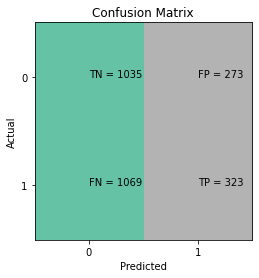

In [ ]:
# make predictions on validation data
y_pred = m5.predict(X_val)

# evaluate model
accuracy, confusion_matrix = evaluate(y_val, y_pred)
print(f'Accuracy: {accuracy}')
plot_confusion_matrix(confusion_matrix)

Make predictions on test images

In [ ]:
# feature extraction - test data
features_test = get_features_m5(test_images)
print(features_test.shape)

# get model predictions
predictions = m5.predict(features_test)
print(predictions)

In [ ]:
import pandas as pd

# Create an array
arr = predictions

# Convert the array into a pandas DataFrame
df = pd.DataFrame(arr, columns=['predictions'])

print(df)

In [ ]:
id_add = df_test

In [ ]:
final=pd.concat([df, id_add], axis=1)

In [ ]:
final.to_csv('submission.csv')

In [ ]:
final.head(10)

In [ ]:
fin_ren = final.rename(columns={'predictions': 'prediction'})

In [ ]:
import json

import pandas as pd

df_test = fin_ren[["id", "prediction"]]

data = []
for index, row in df_test.iterrows():
    data.append({'id': row['id'], 'prediction': row['prediction']})

print(data[0:5])

submission_file_path = "submission.json"
with open(submission_file_path, 'w') as fp:
    fp.write('\n'.join(json.dumps(i) for i in data))


In [ ]:
'''pca = PCA(n_components=2)
pca.fit(X)

X_new = pca.transform(X)


print(f'Shape of transformed data: {X_new.shape}')
print(f'Transformed data:\n {X_new}') '''